# ALEX17 Diurnal Cycles Benchmark: A Large Domain In Complex Terrain
## Introduction
This is the model evaluation notebook of the ALEX17 benchmark. A guide for participants can be found [here](https://thewindvaneblog.com/alex17-diurnal-cycles-benchmark-a-large-domain-in-complex-terrain-b5029e94485).

## Load libraries

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import warnings

from lib.alex17_functions import *  
from lib.nc_read_functions import *  
from IPython.display import Markdown, display
#import ipywidgets as widgets

%load_ext autoreload
%autoreload 2

In [2]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

## Participants

In [21]:
# Read file with simulation descriptions
sims = pd.read_csv('./outputs/alex17_sims.csv')
n_sim = len(sims)
sims

,ID,Plot,Highlight,Ensemble,Save,Participant Number,Participant,Model Name,Input,dx [m],L [km],Remarks,Label
0,alex17_00a,1,1,0,1,0,CENER,WRF,ERA5,3000,28?,Reference simulation for microscale models,WRF_3km
1,alex17_666,1,1,0,1,666,UL Renewables,WRF,ERA5,333,28,Preliminary,WRF_333m
2,alex17_69re,1,1,0,1,69,UL Renewables,WRF-LES,ERA5,111,9,Preliminary,WRF-LES_111m
3,alex17_44,1,1,0,1,44,Meteodyn,Meteodyn MMC,GFS/FNL,50,20,Preliminary,WRF-MeteodynWT
4,alex17_18,1,1,0,1,18,BSC,Alya-RANS,WRF,50,14,Preliminary,WRF-Alya-RANS
5,alex17_20,1,1,0,1,20,DTU,EllipSys3D,WRF,50?,20?,8x(6-h spin-up + 12-h run),WRF-EllipSys3D_QUICK_8x12
6,alex17_21,1,1,0,1,20,DTU,EllipSys3D,WRF,50?,20?,10-min averaged,WRF-EllipSys3D_QUICK_Avg


## Input Data
### Elevation Map and Instrument Layout

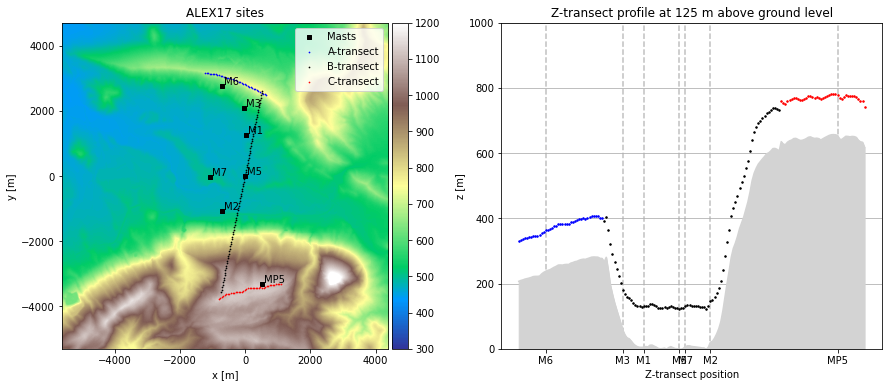

In [4]:
# Site
siteID = 'alex17'

# Evaluation period
datefrom = datetime.datetime(2018,9,30,0,0,0)    
dateto = datetime.datetime(2018,10,4,0,0,0)  

# Mast positions
masts = pd.read_csv('./inputs/masts.csv') # read {x,y,z} coordinates of target masts
masts = masts.drop(masts[masts['Name']=='WLS70'].index)
         
# Z-transect
Ztransect = pd.read_csv('./inputs/Ztransect.csv') # read {x,y,x} coordinates of Z-transect 
A_ind = Ztransect['Name'].str.contains('A') # Tajonar ridge scan
B_ind = Ztransect['Name'].str.contains('B') # Elortz valley scan
C_ind = Ztransect['Name'].str.contains('C') # Alaiz ridge scan

# Topography
topo = rio.open('./inputs/DTM_Alaiz_2m.tif') # read nc file in UTM coordinates
box = [612000 , 622000, 4726000, 4736000]    # evaluation area

# Define local coordinate system
ref = 'M5' # reference site to define origin of coordinate system
ref = masts[masts['Name'] == ref][['easting[m]','northing[m]','elevation[m]']].values[0].tolist()
masts['x'] = masts['easting[m]'] - ref[0]
masts['y'] = masts['northing[m]'] - ref[1]
masts['z'] = masts['elevation[m]'] - ref[2]
Ztransect['x'] = Ztransect['easting[m]'] - ref[0]
Ztransect['y'] = Ztransect['northing[m]'] - ref[1]
Ztransect['z'] = Ztransect['elevation[m]'] - ref[2]
box_xy = [612000 - ref[0], 622000- ref[0], 4726000 - ref[1], 4736000 - ref[1]]    # evaluation area

# Plot elevation map and validation sites
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,6))
basemap = basemap_plot(topo, masts, Ztransect, ref, ax1, coord = 'xy')
ax1.set_xlim(box_xy[0:2])
ax1.set_ylim(box_xy[2:4])
Zprofile = Ztransect_plot(masts, Ztransect, ax2)

### Mesoscale Input Data
Mesoscale simulations have been produced adopting most of the WRF settings that were used in the production run of the New European Wind Atlas (NEWA). Three one-way nested domains of 27, 9 and 3 km resolution are configured centred at the wind farm centroid. The vertical grid has 61 terrain-following (sigma) levels, with 10 levels covering the first 200 meters, more specifically at: 6, 22, 40, 56, 73, 90, 113, 140, 179 and 205 meters. High resolution topography (SRTM 90m) and updated land use categories (Corine Land Cover 2018), together with the Noah land-surface model are used to define the boundary conditions at the surface. The physical parameterizations are: Mellor–Yamada–Nakanishi Niino 2.5-level planetary boundary-layer scheme (MYNN), WRF Single-Moment 5-class microphysics scheme, the Rapid Radiative Transfer Model for GCMs shortwave and longwave radiation schemes and the Kain-Fritsch cumulus scheme in the outermost domains 1 and 2. The simulation is driven by input data from ERA-5 in blocks of 5 days with additional spin-up time of 24 hours.   

From the 3-km domain we extract output data that will be used as reference in validation plots. This constitute the baseline simulation (*alex17_00a*) that we try to improve with microscale modeling. 

In [22]:
# Load WRFref output data
masts_sim = [read_sim('./outputs/alex17_00a_masts.nc')] # mast profiles

#Ztransect_sim = [read_sim('./outputs/alex17_00a_Ztransect.nc')] # Z_transect

#box_sim = [read_sim('./outputs/alex17_00a_box.nc')] # horizontal planes 


./outputs/alex17_00a_masts.nc


## Validation Data
Three sets of measurements will be used for validation of the submitted results. The meteorological mast measurements are available for the modelers to check and calibrate their results, whereas the lidar measurements will be used for validation after submission (blind test). 
1. Vertical profiles at *mast* positions.
2. Wind vector at 125m a.g.l. along the *Z-transect*.
3. Vertical RHI plane across the valley along the *B* segment of the *Z-transect*. The Plane connects WS3 [617846.796; 4732496.246] km and WS5 [617305.590; 4729848.751] km.

In [6]:
# Mast data
masts_obs = read_obs('./observations/masts_obs.nc') # mast profiles

# Z-Transect data
#f_Ztransect = './observations/alex17_Ztransect.nc'



## Simulation Data
We load the simulations defined in *sims* table. Three sets of output data are collected from each simulation: 

1. *simID_masts.nc*: Vertical profiles extending 1km from the surface at the met mast locations (*inputs/masts.csv* coordinates);
2. *simID_Ztransect.nc*: Vertical planes along the Z-transect extending 1 km in the vertical (*inputs/Ztransect.csv* coordinates);
3. *simID_box.nc*: Horizontal planes at 125 m and 40 m a.g.l., with horizontal resolution of 100 m, within the “box” [612–622; 4726–4736] km.

Output data is provided based on 10-min averages.

In [23]:
for i_sim in range(1,n_sim): # i_sim = 0 was already loaded
    masts_sim.append(read_sim('./outputs/'+ sims["ID"][i_sim] +'_masts.nc')) # masts
#    Ztransect_sim.append(read_sim('./outputs/'+ sims["ID"][i_sim] +'_Ztransect.nc'))  # Z-transect planes
#    box_sim.append(read_sim('./outputs/'+ sims["ID"][i_sim] +'_box.nc')) # horizontal planes


./outputs/alex17_666_masts.nc
./outputs/alex17_69re_masts.nc
./outputs/alex17_44_masts.nc
./outputs/alex17_18_masts.nc
./outputs/alex17_20_masts.nc
./outputs/alex17_21_masts.nc


## Quantities of Interest

In [24]:
# turbulence intensity
ti = masts_obs.wind_speed_std / masts_obs.wind_speed
masts_obs = masts_obs.assign(turbulence_intensity = ti)
for i_sim in range(0,n_sim):
    try:
        masts_sim[i_sim].turbulence_intensity
    except AttributeError:
        ti = (((2./3.)*masts_sim[i_sim].specific_turbulent_kinetic_energy)**0.5)/masts_sim[i_sim].wind_speed
        masts_sim[i_sim] = masts_sim[i_sim].assign(turbulence_intensity = ti)

# wind shear 
alpha = np.log(masts_obs.wind_speed.sel(height = 80)/masts_obs.wind_speed.sel(height = 40))/np.log(80./40.)
masts_obs =  masts_obs.assign(wind_shear = alpha)
for i_sim in range(0,n_sim):
    alpha = np.log(masts_sim[i_sim].wind_speed.interp(height= 80)/masts_sim[i_sim].wind_speed.interp(height= 40))/np.log(80./40.)
    masts_sim[i_sim] = masts_sim[i_sim].assign(wind_shear = alpha)

# stability
zL = masts_obs.height / masts_obs.obukhov_length
masts_obs = masts_obs.assign(stability = zL)                            

## Bin-averages

In [25]:
WDbins = np.arange(-5.,360.+5.,10)  # wind direction bins
WDbins_label = np.array([str(k+1) for k in range(36)])  

WDbins = np.array([-15,15])
WDbins_label = ['1']
zLbins = np.array([-1,-0.02, 0.02, 1])      # stability bins
zLbins_label = np.array(['u','n','s'])

bins_label = [WDbins_label, zLbins_label]

WDref = masts_obs.wind_direction.sel(id = 'M7', height = 80)
Sref = masts_obs.wind_speed.sel(id = 'M7', height = 80)
zLref = masts_obs.stability.sel(id = 'M7', height = 10)

N_WDzL, binmap = WDzL_bins(WDref,zLref,Sref,'count',[WDbins, zLbins],[WDbins_label, zLbins_label],plot = False)

masts_obs_mean = dataset_binavrg(masts_obs,binmap,bins_label)
masts_sim_mean = []
for i_sim in range(0,n_sim):
    masts_sim_mean.append(dataset_binavrg(masts_sim[i_sim],binmap,bins_label))
    
N_WDzL.T

,u,n,s
1,41.0,12.0,38.0


## Results

In [26]:
events = {'all'        :[datetime.datetime(2018,9,30,0,0,0),  datetime.datetime(2018,10,3,23,0,0)],
          'neutral'    :[datetime.datetime(2018,10,1,18,0,0), datetime.datetime(2018,10,1,20,0,0)],
          'stable'     :[datetime.datetime(2018,10,2,3,0,0),  datetime.datetime(2018,10,2,5,0,0)], 
          'unstable'   :[datetime.datetime(2018,10,2,12,0,0), datetime.datetime(2018,10,2,14,0,0)],
          'very stable':[datetime.datetime(2018,10,3,4,0,0) , datetime.datetime(2018,10,3,6,0,0)]}

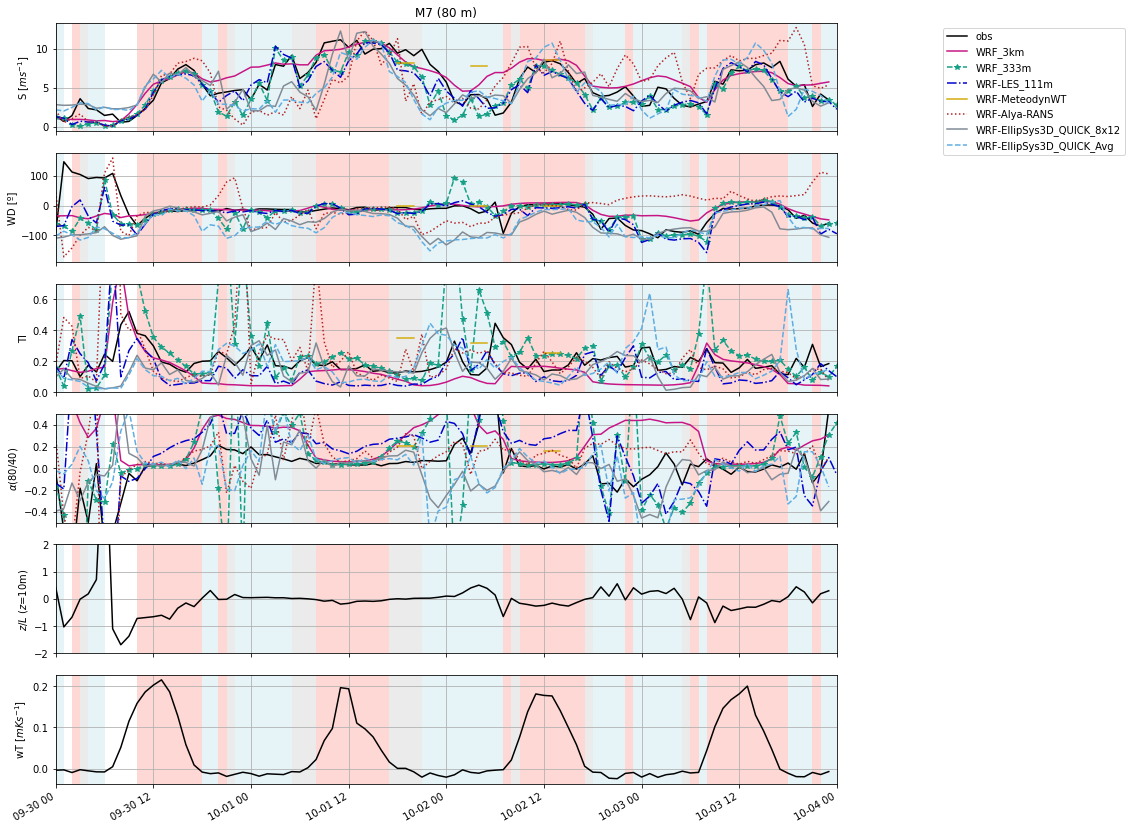

In [28]:
# Plot time-series 
mast = 'M7'
h = 80

ax = mast_sims_vs_obs_timeseries_plot(mast, h, masts_obs, masts_sim, sims, datefrom, dateto, [], binmap)
#plt.savefig('./results/timeseries_M7.png', dpi = 200)

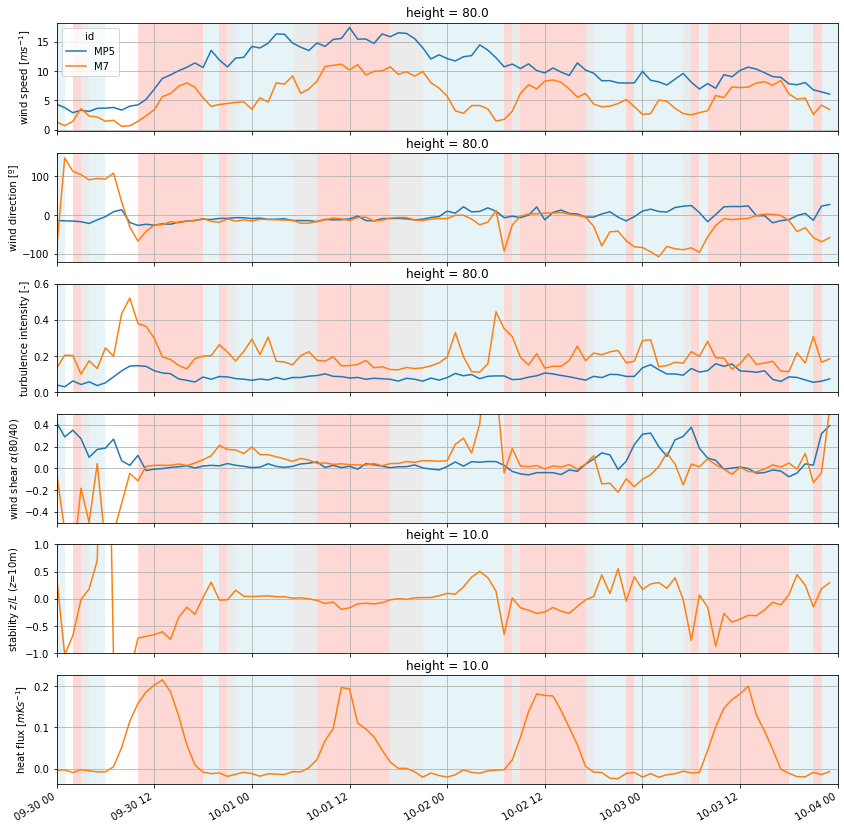

In [13]:
# MP5 vs M7
h = 80.
mast = ['MP5','M7']

ax = compare_masts_timeseries_plot(mast, h, masts_obs, datefrom, dateto, [], binmap)

#masts_obs_quois = events_qois_vs_masts_table(events,masts_obs,h)
#masts_obs_quois[mast]

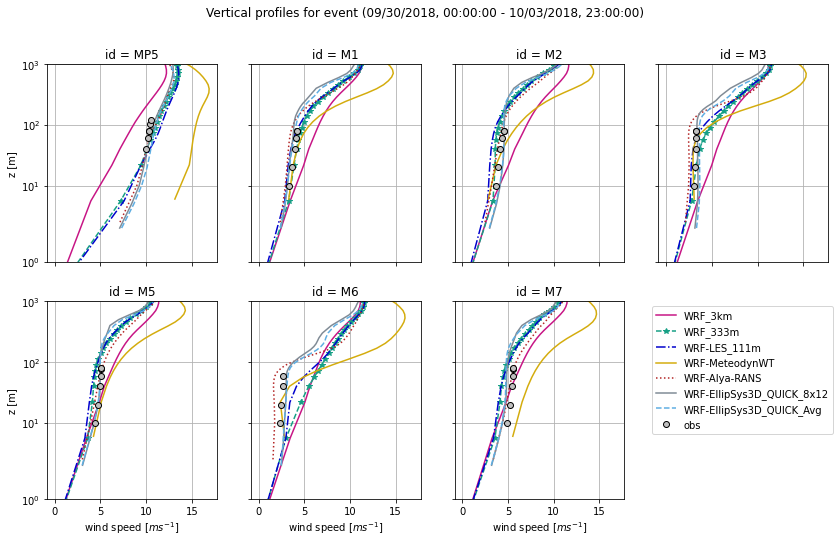

In [29]:
# Vertical profiles at a particular event
select_event = 'all'
ax = masts_sims_vs_obs_profiles_plot(events[select_event], masts_obs, masts_sim, sims)
#widgets.interact(masts_sims_vs_obs_profiles_plot(events[event], masts_obs, masts_sim, sims), event = events)

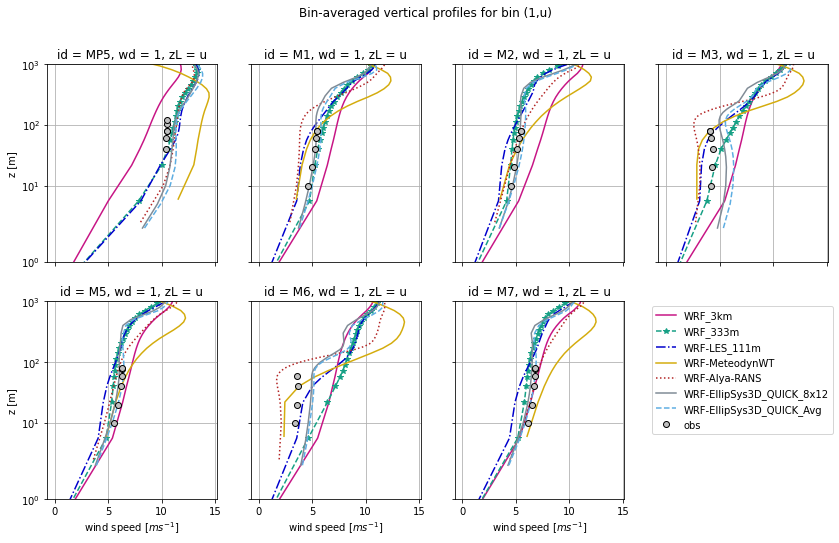

In [35]:
# Bin-averaged vertical profiles
select_bin = ['1','u']
ax = masts_sims_vs_obs_binavrg_profiles_plot(select_bin, masts_obs_mean, masts_sim_mean, sims)
#plt.savefig('./results/profiles_' + select_bin[1] + '.png', dpi = 200)

## Metrics

In [36]:
vars_eval = ['wind_speed','turbulence_intensity','wind_shear']
z_eval = masts_obs_mean.coords['height'].values.tolist()
masts_obs_eval = masts_obs_mean[vars_eval]
masts_sim_eval = []
masts_bias = []; masts_mae = [] # metrics per bin
mean_bias = []; mean_mae = [] # mean metrics all masts and bin combined
for i_sim in range(0,n_sim):
    masts_sim_eval.append(masts_sim_mean[i_sim][vars_eval].interp(height = z_eval))
    masts_sim_eval[i_sim] = masts_sim_eval[i_sim].drop_sel(id = 'WLS70')
    
    masts_bias.append(100*(masts_sim_eval[i_sim] - masts_obs_eval)/masts_obs_eval) # normalized bias in %
    masts_mae.append(abs(masts_bias[i_sim]))
    mean_bias.append(masts_bias[i_sim].mean(dim = ['height','id','wd','zL'], skipna = True))
    mean_mae.append(masts_mae[i_sim].mean(dim = ['height','id','wd','zL'], skipna = True))   
    
# Add sim as xarray dimension
sim_labels = sims['Label'].values
masts_sim_eval = xr.concat([masts_sim_eval[i_sim] for i_sim in range(n_sim)], pd.Index([sim_labels[i_sim] for i_sim in range(n_sim)], name='sim'))
masts_bias = xr.concat([masts_bias[i_sim] for i_sim in range(n_sim)], pd.Index([sim_labels[i_sim] for i_sim in range(n_sim)], name='sim'))
masts_mae = xr.concat([masts_mae[i_sim] for i_sim in range(n_sim)], pd.Index([sim_labels[i_sim] for i_sim in range(n_sim)], name='sim'))
mean_bias = xr.concat([mean_bias[i_sim] for i_sim in range(n_sim)], pd.Index([sim_labels[i_sim] for i_sim in range(n_sim)], name='sim'))
mean_mae = xr.concat([mean_mae[i_sim] for i_sim in range(n_sim)], pd.Index([sim_labels[i_sim] for i_sim in range(n_sim)], name='sim'))


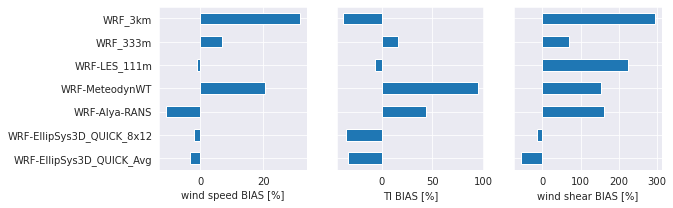

In [38]:
# Plot mean bias
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(9, 3), sharey = True)
    series = mean_bias.wind_speed.to_series()
    series.plot.barh(ax=ax[0]); ax[0].set_xlabel('wind speed BIAS [%]'); ax[0].set_ylabel(''); ax[0].grid(True)
    series = mean_bias.turbulence_intensity.to_series()
    series.plot.barh(ax=ax[1]); ax[1].set_xlabel('TI BIAS [%]'); ax[1].grid(True)
    series = mean_bias.wind_shear.to_series()
    series.plot.barh(ax=ax[2]); ax[2].set_xlabel('wind shear BIAS [%]'); ax[2].grid(True)
    plt.gca().invert_yaxis()
    
plt.savefig('./results/mean_normalized_bias.png', dpi = 200)

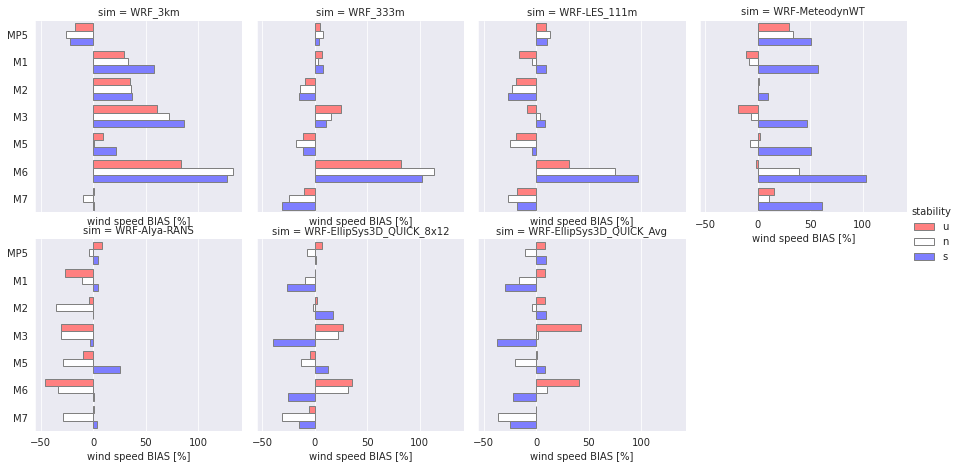

In [42]:
# Plot mast bias
varname = 'wind_speed'
masts_bias_df = masts_bias.sel(wd = '1').mean(dim = ['height'],skipna = True).to_dataframe()  
masts_bias_df.reset_index(inplace=True)

with sns.axes_style('darkgrid'):
    ax = sns.catplot(x=varname, y='id', hue='zL', col='sim', col_wrap=4,
                    data=masts_bias_df, kind='bar',height=3.2, aspect=1, 
                    palette = 'bwr_r',edgecolor='grey',saturation=1);
    ax.set(xlabel='wind speed BIAS [%]', ylabel = '')
    ax._legend.set_title('stability')

plt.savefig('./results/' + varname + '_bias.png', dpi = 200)

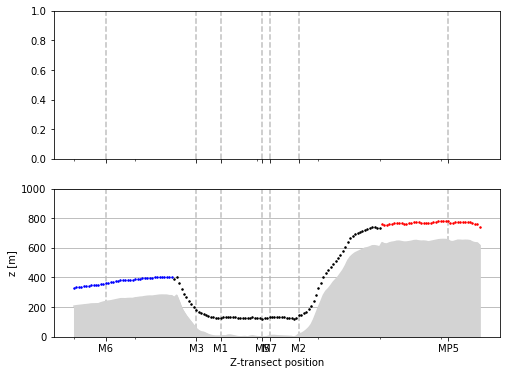

In [43]:
# Plot Z-transect
h = 125.

#ax = Ztransect_sims_vs_obs_plot(t, Ztransect_obs, Ztransect_sim, masts, Ztransect)
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (8,6), sharex = True)
Zprofile = Ztransect_plot(masts, Ztransect, ax2)
ax2.set_title('')
#for i_sim in range (0,n_sim):
    #Ztransect_sim[i_sim].wind_speed.sel(height = h).plot(x = 'id', label = sims['ID'][i_sim], ax = ax1)
#ax1.legend(bbox_to_anchor=(1, 1))
masts_inZ = [] # index of Z_transect position nearest to each mast
for i, row in masts.iterrows():
    d = np.sqrt((Ztransect['x'] - masts['x'][i])**2 + (Ztransect['y'] - masts['y'][i])**2)
    masts_inZ.append(d[d == d.min()].index[0])
for x in masts_inZ:
    ax1.axvline(x, color = 'silver', linestyle = '--', zorder = 0)


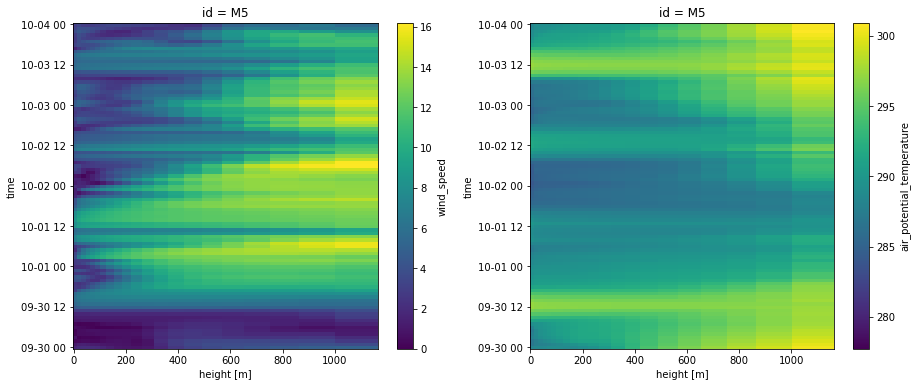

In [44]:
# tz contour plot
i_sim = 1
mast = 'M5'
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,6))
ax1 = masts_sim[i_sim].wind_speed.sel(id = mast).plot(ax = ax1)
ax2 = masts_sim[i_sim].air_potential_temperature.sel(id = mast).plot(ax = ax2);

In [45]:
# xy contour plots
i_sim = 2
h = 125.
t = events['neutral'][0]

S = box_sim[i_sim].wind_speed.sel(time = t, height = h)
TKE = box_sim[i_sim].specific_turbulent_kinetic_energy.sel(time = t, height = h)

oview = topo.overviews(1)[2] # choose overview (0 is largest, -1 is the smallest)
basemap = topo.read(1, out_shape=(1, int(topo.height // oview), int(topo.width // oview)))
basemap = np.ma.masked_where(basemap == 0 , basemap, copy=True) 
basemap = np.flipud(basemap)
min_E, max_E = topo.bounds.left, topo.bounds.right
min_N, max_N = topo.bounds.bottom, topo.bounds.top
res = (max_E-min_E)*oview/topo.width
X, Y = np.meshgrid(np.arange(min_E + res/2, max_E - res/2, res), np.arange(min_N + res/2, max_N - res/2, res))

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,6))
h_box = S.plot(x = 'easting', y = 'northing', ax = ax1)
ctopo = ax1.contour(X,Y,basemap, colors = 'grey', levels = list(range(0, 3000, 100)))
ax1.clabel(ctopo, inline=1, fontsize=10, fmt = '%i')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]') 

h_box = TKE.plot(x = 'easting', y = 'northing', ax = ax2)
ctopo = ax2.contour(X,Y,basemap, colors = 'grey', levels = list(range(0, 3000, 100)))
ax2.clabel(ctopo, inline=1, fontsize=10, fmt = '%i')
ax2.set_xlabel('Easting [m]')
ax2.set_ylabel('Northing [m]'); 

NameError: name 'box_sim' is not defined